# VARIMA Weather Forecasting

This notebook trains a VARIMA (Vector AutoRegressive Integrated Moving Average) model for weather forecasting.

**Model Type**: Multivariate time series
**Approach**: Single model predicting all 3 variables simultaneously
**Target Variables**: temperature, relative_humidity, wind_speed_10m
**Prediction Window**: 72 hours (3 days)
**Training**: CPU-friendly, completes in ~20-40 minutes

**Key Advantage**: VARIMA captures interdependencies between variables (e.g., temperature affects humidity)

## 1. Setup & Installation

In [1]:
# Install required packages
import subprocess
import sys

packages = [
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'statsmodels',
    'joblib',
    'tqdm'
]

print("Installing packages...")
for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
print("✅ All packages installed!")

Installing packages...
✅ All packages installed!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import json
import warnings
from tqdm import tqdm
import time
from pathlib import Path

warnings.filterwarnings('ignore')

print("✅ Imports successful!")

✅ Imports successful!


## 2. Configuration

In [3]:
config = {
    # Data paths
    'data_path': '../data/Weather_Data_1980_2024(hourly).csv',
    'models_dir': '../models',

    # Target variables to predict (multivariate)
    'target_variables': [
        'temperature',
        'relative_humidity',
        'wind_speed_10m (km/h)'
    ],

    # All input features (for context)
    'input_features': [
        'temperature',
        'relative_humidity',
        'dew_point',
        'wind_speed_10m (km/h)',
        'pressure_msl (hPa)',
        'cloud_cover (%)',
        'vapour_pressure_deficit (kPa)'
    ],

    # Data split
    'train_split': 0.8,
    'val_split': 0.1,  # Remaining 0.1 for test

    # Forecast settings
    'forecast_horizon': 72,  # 3 days in hours

    # VARIMA settings (we'll use VAR for simplicity if data is stationary)
    'var_order': None,  # Will be auto-selected
    'max_lags': 24,  # Maximum lags to test (1 day)

    # Normalization
    'normalize': True
}

print("Configuration:")
print(json.dumps({k: v for k, v in config.items()}, indent=2))

Configuration:
{
  "data_path": "../data/Weather_Data_1980_2024(hourly).csv",
  "models_dir": "../models",
  "target_variables": [
    "temperature",
    "relative_humidity",
    "wind_speed_10m (km/h)"
  ],
  "input_features": [
    "temperature",
    "relative_humidity",
    "dew_point",
    "wind_speed_10m (km/h)",
    "pressure_msl (hPa)",
    "cloud_cover (%)",
    "vapour_pressure_deficit (kPa)"
  ],
  "train_split": 0.8,
  "val_split": 0.1,
  "forecast_horizon": 72,
  "var_order": null,
  "max_lags": 24,
  "normalize": true
}


## 3. Load and Prepare Data

In [4]:
print("Loading data...")
df = pd.read_csv(config['data_path'])

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Check for missing values
print(f"\nMissing values:")
print(df[config['input_features']].isnull().sum())

Loading data...
Dataset shape: (389496, 17)
Columns: ['time', 'temperature', 'relative_humidity', 'dew_point', 'precipitation (mm)', 'rain (mm)', 'snowfall (cm)', 'pressure_msl (hPa)', 'surface_pressure (hPa)', 'cloud_cover (%)', 'cloud_cover_low (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)', 'vapour_pressure_deficit (kPa)', 'wind_speed_10m (km/h)', 'wind_direction', 'is_Day']

First few rows:
               time  temperature  relative_humidity  dew_point  \
0  1980-01-01T00:00         12.7                 83       10.0   
1  1980-01-01T01:00         12.9                 82        9.9   
2  1980-01-01T02:00         13.2                 82       10.2   
3  1980-01-01T03:00         15.9                 78       12.0   
4  1980-01-01T04:00         19.4                 67       13.1   

   precipitation (mm)  rain (mm)  snowfall (cm)  pressure_msl (hPa)  \
0                 0.0        0.0              0              1012.8   
1                 0.0        0.0              0           

In [5]:
# Clean data - remove missing values
df_clean = df[config['target_variables']].dropna().reset_index(drop=True)

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Removed {len(df) - len(df_clean)} rows with missing values")

# Calculate split indices
total_len = len(df_clean)
train_idx = int(config['train_split'] * total_len)
val_idx = train_idx + int(config['val_split'] * total_len)

print(f"\nData split:")
print(f"  Train: 0 to {train_idx} ({train_idx:,} samples)")
print(f"  Val: {train_idx} to {val_idx} ({val_idx - train_idx:,} samples)")
print(f"  Test: {val_idx} to {total_len} ({total_len - val_idx:,} samples)")

Clean dataset shape: (389496, 3)
Removed 0 rows with missing values

Data split:
  Train: 0 to 311596 (311,596 samples)
  Val: 311596 to 350545 (38,949 samples)
  Test: 350545 to 389496 (38,951 samples)


## 4. Normalize Data (Optional but Recommended)

In [6]:
if config['normalize']:
    print("Normalizing data...")
    scaler = MinMaxScaler()

    # Fit on training data only
    train_data = df_clean.iloc[:train_idx].values
    scaler.fit(train_data)

    # Transform all data
    data_normalized = scaler.transform(df_clean.values)
    df_normalized = pd.DataFrame(data_normalized,
                                 columns=config['target_variables'],
                                 index=df_clean.index)

    print("✅ Data normalized using MinMaxScaler")
    print(f"   Scale range: {scaler.data_min_} to {scaler.data_max_}")
else:
    df_normalized = df_clean.copy()
    scaler = None
    print("⚠️ Using raw data (no normalization)")

# Split normalized data
train_data = df_normalized.iloc[:train_idx]
val_data = df_normalized.iloc[train_idx:val_idx]
test_data = df_normalized.iloc[val_idx:]

print(f"\nNormalized data splits:")
print(f"  Train: {train_data.shape}")
print(f"  Val: {val_data.shape}")
print(f"  Test: {test_data.shape}")

Normalizing data...
✅ Data normalized using MinMaxScaler
   Scale range: [8. 6. 0.] to [ 41.2 100.   40.3]

Normalized data splits:
  Train: (311596, 3)
  Val: (38949, 3)
  Test: (38951, 3)


## 5. Exploratory Data Analysis - Variable Correlations

📊 Saved correlation matrix to models/varima_correlation_matrix.png


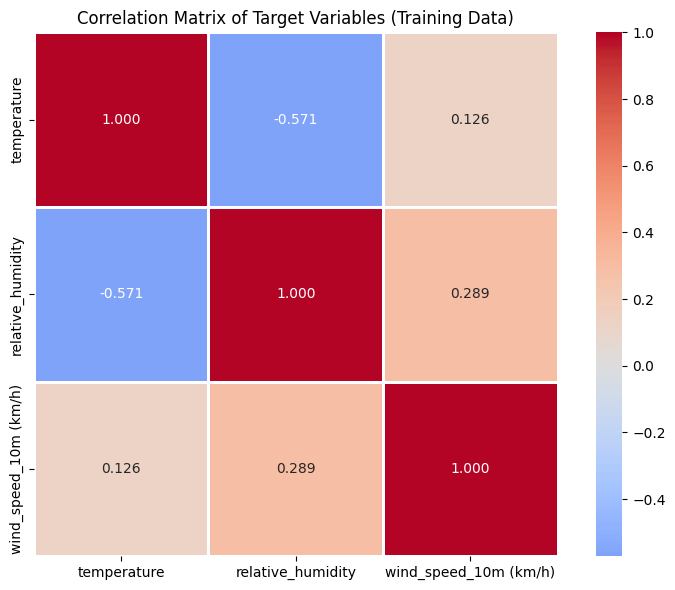


📊 Variable Correlations:
                       temperature  relative_humidity  wind_speed_10m (km/h)
temperature               1.000000          -0.570965               0.126461
relative_humidity        -0.570965           1.000000               0.289320
wind_speed_10m (km/h)     0.126461           0.289320               1.000000


In [7]:
# Plot correlation matrix
plt.figure(figsize=(8, 6))
correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, fmt='.3f')
plt.title('Correlation Matrix of Target Variables (Training Data)')
plt.tight_layout()
plt.savefig('../models/varima_correlation_matrix.png', dpi=150, bbox_inches='tight')
print("📊 Saved correlation matrix to models/varima_correlation_matrix.png")
plt.show()

print("\n📊 Variable Correlations:")
print(correlation_matrix)

## 6. Select Optimal VAR Order

We'll use the VAR model's built-in AIC/BIC selection to find optimal lag order.

In [8]:
print("\n🔍 Selecting optimal VAR order using AIC...")
print("This may take a few minutes...")

start_time = time.time()

# Fit VAR model for order selection
var_model = VAR(train_data)

# Select order based on AIC
# Note: We limit to max_lags to keep training time reasonable
order_selection = var_model.select_order(maxlags=config['max_lags'])

print(f"\n✅ Order selection completed in {time.time() - start_time:.1f}s")
print("\nOrder selection criteria:")
print(order_selection.summary())

# Use AIC-optimal order
optimal_order = order_selection.aic
config['var_order'] = optimal_order

print(f"\n🎯 Selected order: {optimal_order} (based on AIC)")


🔍 Selecting optimal VAR order using AIC...
This may take a few minutes...

✅ Order selection completed in 55.1s

Order selection criteria:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -10.90      -10.90   1.855e-05      -10.90
1       -20.66      -20.66   1.060e-09      -20.66
2       -22.18      -22.18   2.335e-10      -22.18
3       -22.24      -22.24   2.192e-10      -22.24
4       -22.27      -22.27   2.121e-10      -22.27
5       -22.30      -22.29   2.076e-10      -22.30
6       -22.32      -22.31   2.033e-10      -22.32
7       -22.33      -22.33   2.006e-10      -22.33
8       -22.34      -22.34   1.988e-10      -22.34
9       -22.35      -22.35   1.968e-10      -22.35
10      -22.37      -22.36   1.930e-10      -22.37
11      -22.38      -22.37   1.911e-10      -22.38
12      -22.41      -22.41   1.853e-10      -22.41
13      -22.46      -22.46   1.752e-10      

## 7. Train VAR Model

In [9]:
print("\n" + "="*80)
print(f"Training VAR({optimal_order}) model...")
print("="*80)

start_time = time.time()

# Fit VAR model
var_fitted = var_model.fit(maxlags=optimal_order)

train_time = time.time() - start_time
print(f"\n✅ VAR model trained in {train_time:.1f}s")

# Model summary
print("\n📊 Model Summary:")
print(var_fitted.summary())


Training VAR(24) model...

✅ VAR model trained in 4.9s

📊 Model Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Oct, 2025
Time:                     17:11:03
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.3005
Nobs:                     311572.    HQIC:                  -23.3058
Log likelihood:       2.30497e+06    FPE:                7.54188e-11
AIC:                     -23.3080    Det(Omega_mle):     7.53658e-11
--------------------------------------------------------------------
Results for equation temperature
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.002164         0.000174           12.435           0.000
L1.temperature           

## 8. Validation and Testing

Note: VAR requires recursive forecasting - we predict step by step.

In [10]:
def forecast_var(model, data, steps, initial_window=None):
    """
    Forecast using VAR model with rolling window approach.

    Args:
        model: Fitted VAR model
        data: Historical data
        steps: Number of steps to forecast
        initial_window: Data to use as initial values (if None, uses end of data)

    Returns:
        Array of forecasts
    """
    if initial_window is None:
        initial_window = data.values[-model.k_ar:]
    else:
        initial_window = initial_window[-model.k_ar:]

    forecasts = []
    current_window = initial_window.copy()

    for _ in range(steps):
        # Forecast next step
        forecast = model.forecast(current_window, steps=1)
        forecasts.append(forecast[0])

        # Update window (rolling)
        current_window = np.vstack([current_window[1:], forecast])

    return np.array(forecasts)

In [11]:
# Validation
print("\n📊 Validating on validation set...")
val_start_time = time.time()

# Get initial window from end of training data
initial_window_val = train_data.values[-optimal_order:]

# Forecast validation period
val_forecast = forecast_var(var_fitted, train_data, len(val_data), initial_window_val)

val_time = time.time() - val_start_time

# Calculate metrics per variable
val_metrics = {}
for i, var_name in enumerate(config['target_variables']):
    actual = val_data[var_name].values
    predicted = val_forecast[:, i]

    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)

    val_metrics[var_name] = {
        'mse': mse,
        'mae': mae,
        'rmse': rmse
    }

    print(f"\n{var_name}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")

print(f"\nValidation time: {val_time:.1f}s")


📊 Validating on validation set...

temperature:
  MSE: 0.023109
  MAE: 0.113836
  RMSE: 0.152015

relative_humidity:
  MSE: 0.066993
  MAE: 0.223187
  RMSE: 0.258830

wind_speed_10m (km/h):
  MSE: 0.021776
  MAE: 0.119679
  RMSE: 0.147566

Validation time: 4.5s


In [12]:
# Test set evaluation
print("\n📈 Testing on test set...")

# Retrain on train + val for final predictions
train_val_data = df_normalized.iloc[:val_idx]
var_model_final = VAR(train_val_data)
var_fitted_final = var_model_final.fit(maxlags=optimal_order)

test_start_time = time.time()

# Forecast test period
initial_window_test = train_val_data.values[-optimal_order:]
test_forecast = forecast_var(var_fitted_final, train_val_data, len(test_data), initial_window_test)

test_time = time.time() - test_start_time

# Calculate metrics per variable
test_metrics = {}
for i, var_name in enumerate(config['target_variables']):
    actual = test_data[var_name].values
    predicted = test_forecast[:, i]

    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)

    test_metrics[var_name] = {
        'mse': mse,
        'mae': mae,
        'rmse': rmse
    }

    print(f"\n{var_name}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")

print(f"\nTest time: {test_time:.1f}s")


📈 Testing on test set...

temperature:
  MSE: 0.024749
  MAE: 0.119263
  RMSE: 0.157317

relative_humidity:
  MSE: 0.070875
  MAE: 0.230695
  RMSE: 0.266223

wind_speed_10m (km/h):
  MSE: 0.019895
  MAE: 0.113543
  RMSE: 0.141049

Test time: 4.1s


## 9. Visualize Predictions

📊 Saved predictions plot to models/varima_predictions.png


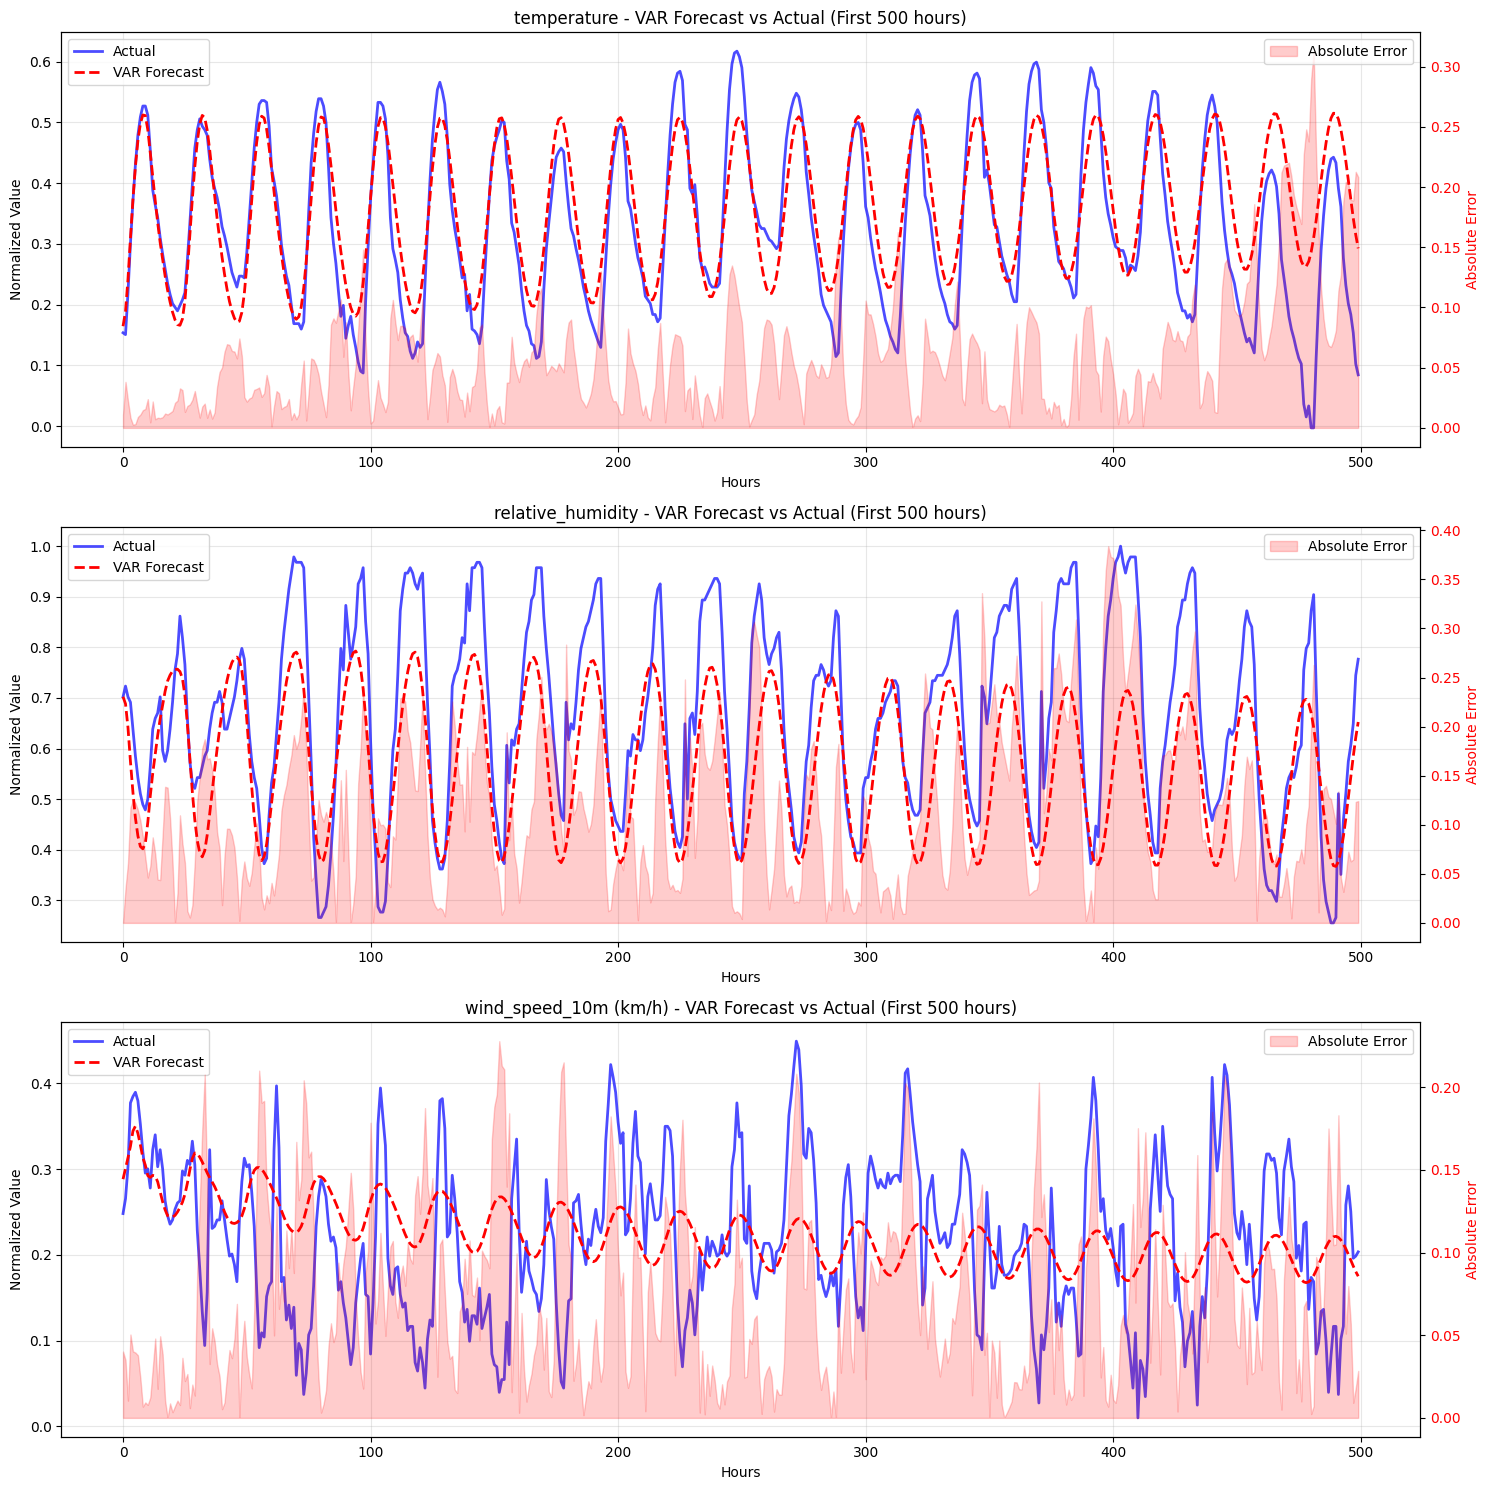

In [13]:
# Plot test predictions for each variable
fig, axes = plt.subplots(len(config['target_variables']), 1,
                         figsize=(15, 5*len(config['target_variables'])))

if len(config['target_variables']) == 1:
    axes = [axes]

for idx, target_var in enumerate(config['target_variables']):
    ax = axes[idx]

    # Get data
    actual = test_data[target_var].values
    predicted = test_forecast[:, idx]

    # Plot first 500 hours of test set
    plot_len = min(500, len(actual))
    time_steps = np.arange(plot_len)

    ax.plot(time_steps, actual[:plot_len], 'b-', label='Actual', alpha=0.7, linewidth=2)
    ax.plot(time_steps, predicted[:plot_len], 'r--', label='VAR Forecast', linewidth=2)

    # Calculate error
    error = np.abs(actual[:plot_len] - predicted[:plot_len])
    ax2 = ax.twinx()
    ax2.fill_between(time_steps, 0, error, alpha=0.2, color='red', label='Absolute Error')
    ax2.set_ylabel('Absolute Error', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax.set_xlabel('Hours')
    ax.set_ylabel('Normalized Value')
    ax.set_title(f'{target_var} - VAR Forecast vs Actual (First 500 hours)')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/varima_predictions.png', dpi=150, bbox_inches='tight')
print("📊 Saved predictions plot to models/varima_predictions.png")
plt.show()

📊 Saved 72-hour forecast plot to models/varima_72hour_forecast.png


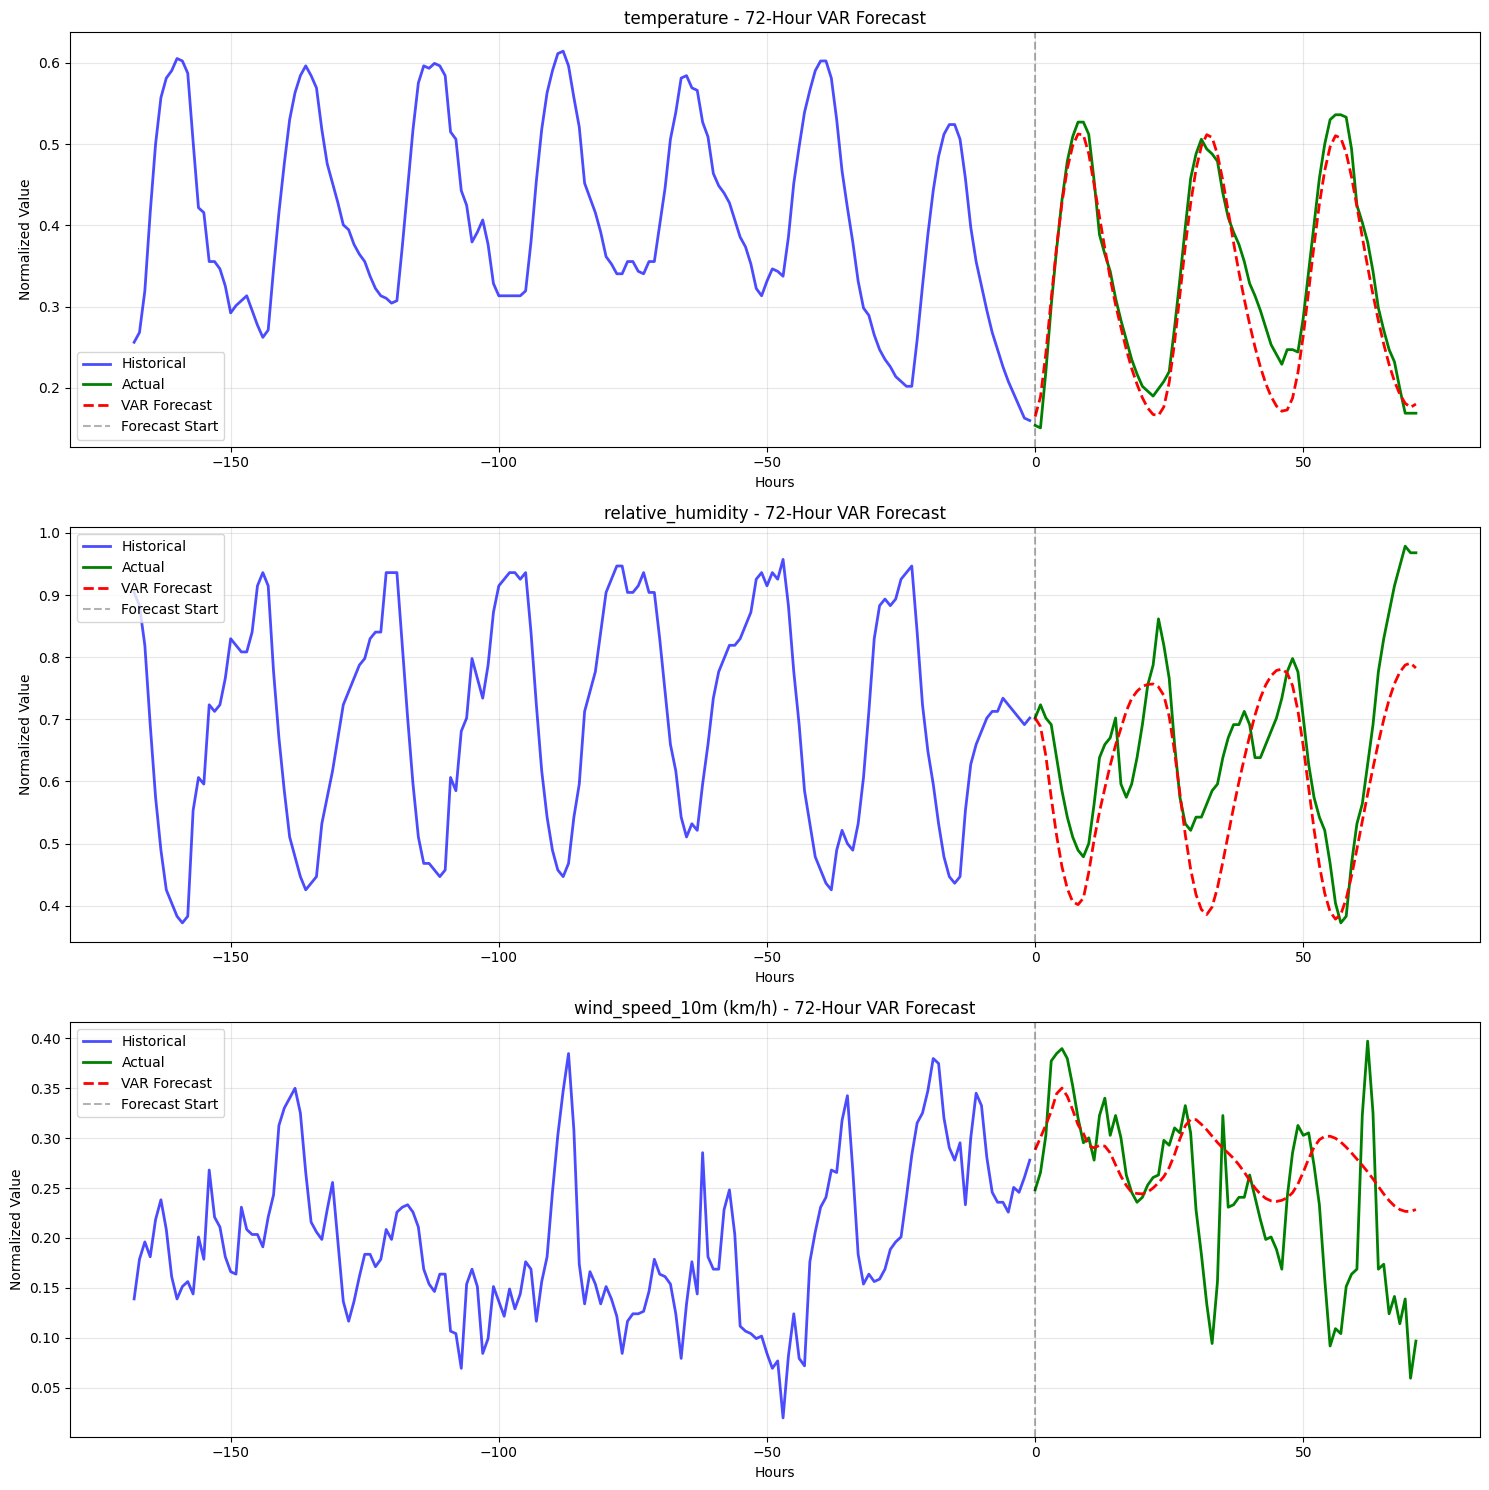

In [14]:
# Plot 72-hour forecast example
fig, axes = plt.subplots(len(config['target_variables']), 1,
                         figsize=(15, 5*len(config['target_variables'])))

if len(config['target_variables']) == 1:
    axes = [axes]

history_len = 168  # Show 7 days of history

for idx, target_var in enumerate(config['target_variables']):
    ax = axes[idx]

    # Get data
    history = df_normalized[target_var].iloc[val_idx - history_len:val_idx].values
    actual = test_data[target_var].iloc[:config['forecast_horizon']].values
    predicted = test_forecast[:config['forecast_horizon'], idx]

    # Time arrays
    hist_time = np.arange(-history_len, 0)
    pred_time = np.arange(0, config['forecast_horizon'])

    # Plot
    ax.plot(hist_time, history, 'b-', label='Historical', alpha=0.7, linewidth=2)
    ax.plot(pred_time, actual, 'g-', label='Actual', linewidth=2)
    ax.plot(pred_time, predicted, 'r--', label='VAR Forecast', linewidth=2)

    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3, label='Forecast Start')
    ax.set_xlabel('Hours')
    ax.set_ylabel('Normalized Value')
    ax.set_title(f'{target_var} - 72-Hour VAR Forecast')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/varima_72hour_forecast.png', dpi=150, bbox_inches='tight')
print("📊 Saved 72-hour forecast plot to models/varima_72hour_forecast.png")
plt.show()

## 10. Analyze Forecast Degradation Over Time

📊 Saved horizon analysis to models/varima_horizon_analysis.png


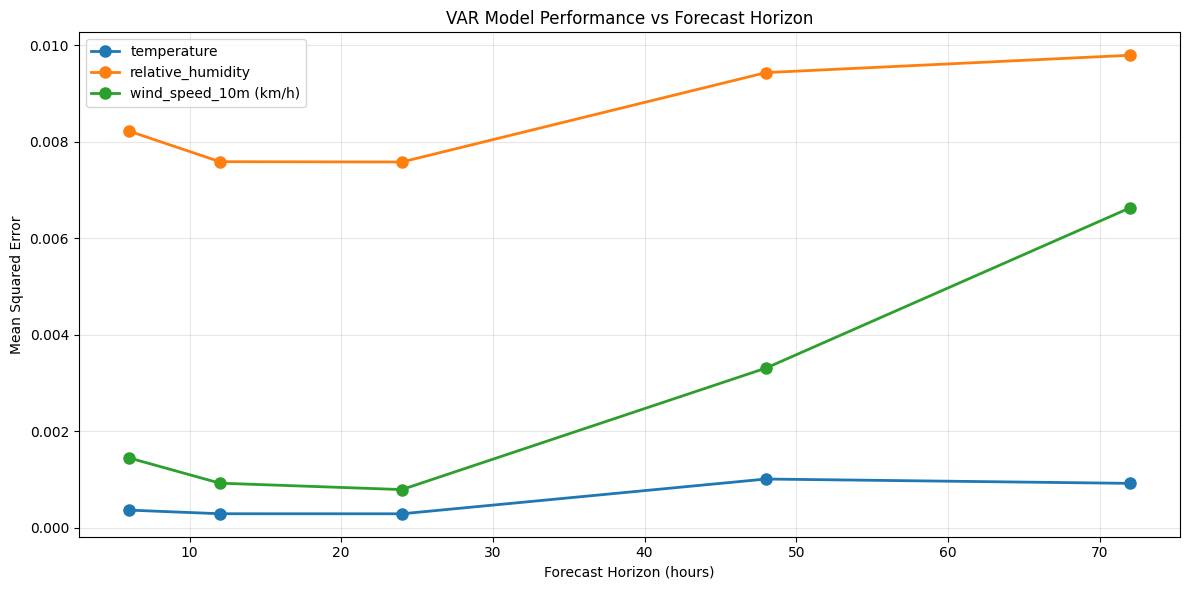

In [15]:
# Calculate MSE for different forecast horizons
horizons = [6, 12, 24, 48, 72]  # 6h, 12h, 1d, 2d, 3d
horizon_metrics = {h: {} for h in horizons}

for horizon in horizons:
    if horizon <= len(test_data):
        for i, var_name in enumerate(config['target_variables']):
            actual = test_data[var_name].iloc[:horizon].values
            predicted = test_forecast[:horizon, i]

            mse = mean_squared_error(actual, predicted)
            horizon_metrics[horizon][var_name] = mse

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

for i, var_name in enumerate(config['target_variables']):
    mse_values = [horizon_metrics[h][var_name] for h in horizons]
    ax.plot(horizons, mse_values, marker='o', label=var_name, linewidth=2, markersize=8)

ax.set_xlabel('Forecast Horizon (hours)')
ax.set_ylabel('Mean Squared Error')
ax.set_title('VAR Model Performance vs Forecast Horizon')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../models/varima_horizon_analysis.png', dpi=150, bbox_inches='tight')
print("📊 Saved horizon analysis to models/varima_horizon_analysis.png")
plt.show()

## 11. Impulse Response Analysis

Shows how a shock to one variable affects others over time (VAR advantage!)


📊 Computing Impulse Response Functions...
📊 Saved impulse response plot to models/varima_impulse_response.png


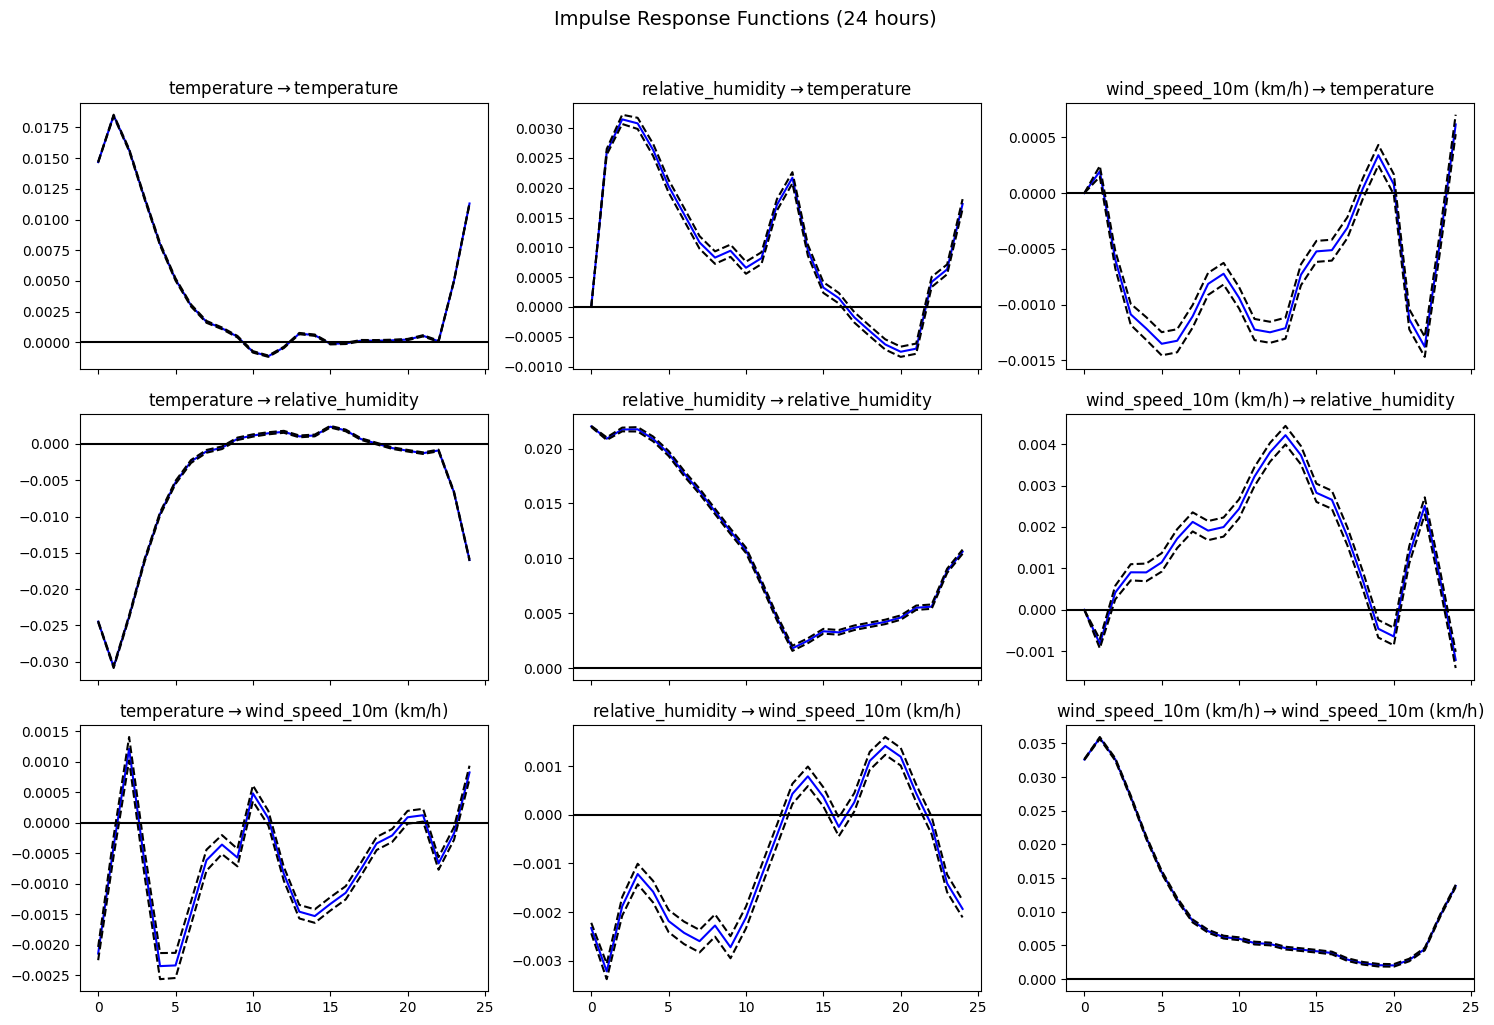


💡 Interpretation:
   - Diagonal plots: How each variable responds to its own shocks
   - Off-diagonal: How one variable affects another over time
   - This shows the multivariate relationships VAR captures!


In [17]:
# Compute impulse response functions
print("\n📊 Computing Impulse Response Functions...")
irf = var_fitted_final.irf(periods=24)  # 24 hours

# Plot - don't specify impulse/response, let it plot all combinations
fig = irf.plot(orth=True, figsize=(15, 10))
plt.suptitle('Impulse Response Functions (24 hours)', y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig('../models/varima_impulse_response.png', dpi=150, bbox_inches='tight')
print("📊 Saved impulse response plot to models/varima_impulse_response.png")
plt.show()

print("\n💡 Interpretation:")
print("   - Diagonal plots: How each variable responds to its own shocks")
print("   - Off-diagonal: How one variable affects another over time")
print("   - This shows the multivariate relationships VAR captures!")

## 12. Save Model and Results

In [19]:
# Create models directory if it doesn't exist
models_dir = Path(config['models_dir'])
models_dir.mkdir(exist_ok=True)

print("\n💾 Saving VAR model and artifacts...")

# Save fitted VAR model
model_path = models_dir / 'varima_model.pkl'
joblib.dump(var_fitted_final, model_path)
print(f"  ✓ Saved varima_model.pkl")

# Save scaler if used
if scaler is not None:
    scaler_path = models_dir / 'varima_scaler.pkl'
    joblib.dump(scaler, scaler_path)
    print(f"  ✓ Saved varima_scaler.pkl")

# Save results
results = {
    'order': int(optimal_order),  # Convert numpy int64 to Python int
    'training_time': float(train_time),
    'validation_time': float(val_time),
    'test_time': float(test_time),
    'normalized': config['normalize'],
    'validation_metrics': {
        var: {k: float(v) for k, v in metrics.items()}
        for var, metrics in val_metrics.items()
    },
    'test_metrics': {
        var: {k: float(v) for k, v in metrics.items()}
        for var, metrics in test_metrics.items()
    },
    'horizon_metrics': {
        str(h): {var: float(mse) for var, mse in metrics.items()}
        for h, metrics in horizon_metrics.items()
    }
}

results_path = models_dir / 'varima_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"  ✓ Saved varima_results.json")

# Save configuration
config_path = models_dir / 'varima_config.json'
with open(config_path, 'w') as f:
    # Convert config to JSON-safe format
    config_safe = {}
    for k, v in config.items():
        if isinstance(v, np.integer):
            config_safe[k] = int(v)
        elif isinstance(v, np.floating):
            config_safe[k] = float(v)
        elif isinstance(v, np.ndarray):
            config_safe[k] = v.tolist()
        else:
            config_safe[k] = v
    json.dump(config_safe, f, indent=2)
print(f"  ✓ Saved varima_config.json")

print("\n✅ All VAR/VARIMA artifacts saved successfully!")
print(f"📁 Location: {models_dir.absolute()}")


💾 Saving VAR model and artifacts...
  ✓ Saved varima_model.pkl
  ✓ Saved varima_scaler.pkl
  ✓ Saved varima_results.json
  ✓ Saved varima_config.json

✅ All VAR/VARIMA artifacts saved successfully!
📁 Location: D:\devs\weather\notebooks\..\models


## 13. Summary & Next Steps

In [20]:
print("\n" + "="*80)
print("🎉 VARIMA Training Complete!")
print("="*80)

print(f"\n📊 Model Configuration:")
print(f"  Order: VAR({optimal_order})")
print(f"  Variables: {len(config['target_variables'])} (multivariate)")
print(f"  Normalized: {config['normalize']}")
print(f"  Training time: {train_time:.1f}s")

print(f"\n📈 Test Performance:")
for var in config['target_variables']:
    metrics = test_metrics[var]
    print(f"\n{var}:")
    print(f"  MSE: {metrics['mse']:.6f}")
    print(f"  MAE: {metrics['mae']:.6f}")
    print(f"  RMSE: {metrics['rmse']:.6f}")

print("\n📁 Saved Files:")
print(f"  - VAR model: {models_dir}/varima_model.pkl")
if scaler:
    print(f"  - Scaler: {models_dir}/varima_scaler.pkl")
print(f"  - Results: {models_dir}/varima_results.json")
print(f"  - Configuration: {models_dir}/varima_config.json")
print(f"  - Plots: {models_dir}/varima_*.png")

print("\n💡 Key Insights:")
print("  - VAR captures multivariate relationships between weather variables")
print("  - Impulse response functions show how variables influence each other")
print("  - Performance may degrade over longer forecast horizons")

print("\n🔜 Next Steps:")
print("  1. Train LSTM model: Run train_lstm.py (on Colab recommended)")
print("  2. Compare all models: Run model_comparison.py")
print("  3. Analyze which model works best for your use case!")

print("\n" + "="*80)


🎉 VARIMA Training Complete!

📊 Model Configuration:
  Order: VAR(24)
  Variables: 3 (multivariate)
  Normalized: True
  Training time: 4.9s

📈 Test Performance:

temperature:
  MSE: 0.024749
  MAE: 0.119263
  RMSE: 0.157317

relative_humidity:
  MSE: 0.070875
  MAE: 0.230695
  RMSE: 0.266223

wind_speed_10m (km/h):
  MSE: 0.019895
  MAE: 0.113543
  RMSE: 0.141049

📁 Saved Files:
  - VAR model: ..\models/varima_model.pkl
  - Scaler: ..\models/varima_scaler.pkl
  - Results: ..\models/varima_results.json
  - Configuration: ..\models/varima_config.json
  - Plots: ..\models/varima_*.png

💡 Key Insights:
  - VAR captures multivariate relationships between weather variables
  - Impulse response functions show how variables influence each other
  - Performance may degrade over longer forecast horizons

🔜 Next Steps:
  1. Train LSTM model: Run train_lstm.py (on Colab recommended)
  2. Compare all models: Run model_comparison.py
  3. Analyze which model works best for your use case!

